In [119]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jgfdlkjhgf/wallpaperflare.com_wallpaper(8).jpg
/kaggle/input/jgfdlkjhgf/wallpaperflare.com_wallpaper(5).jpg
/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


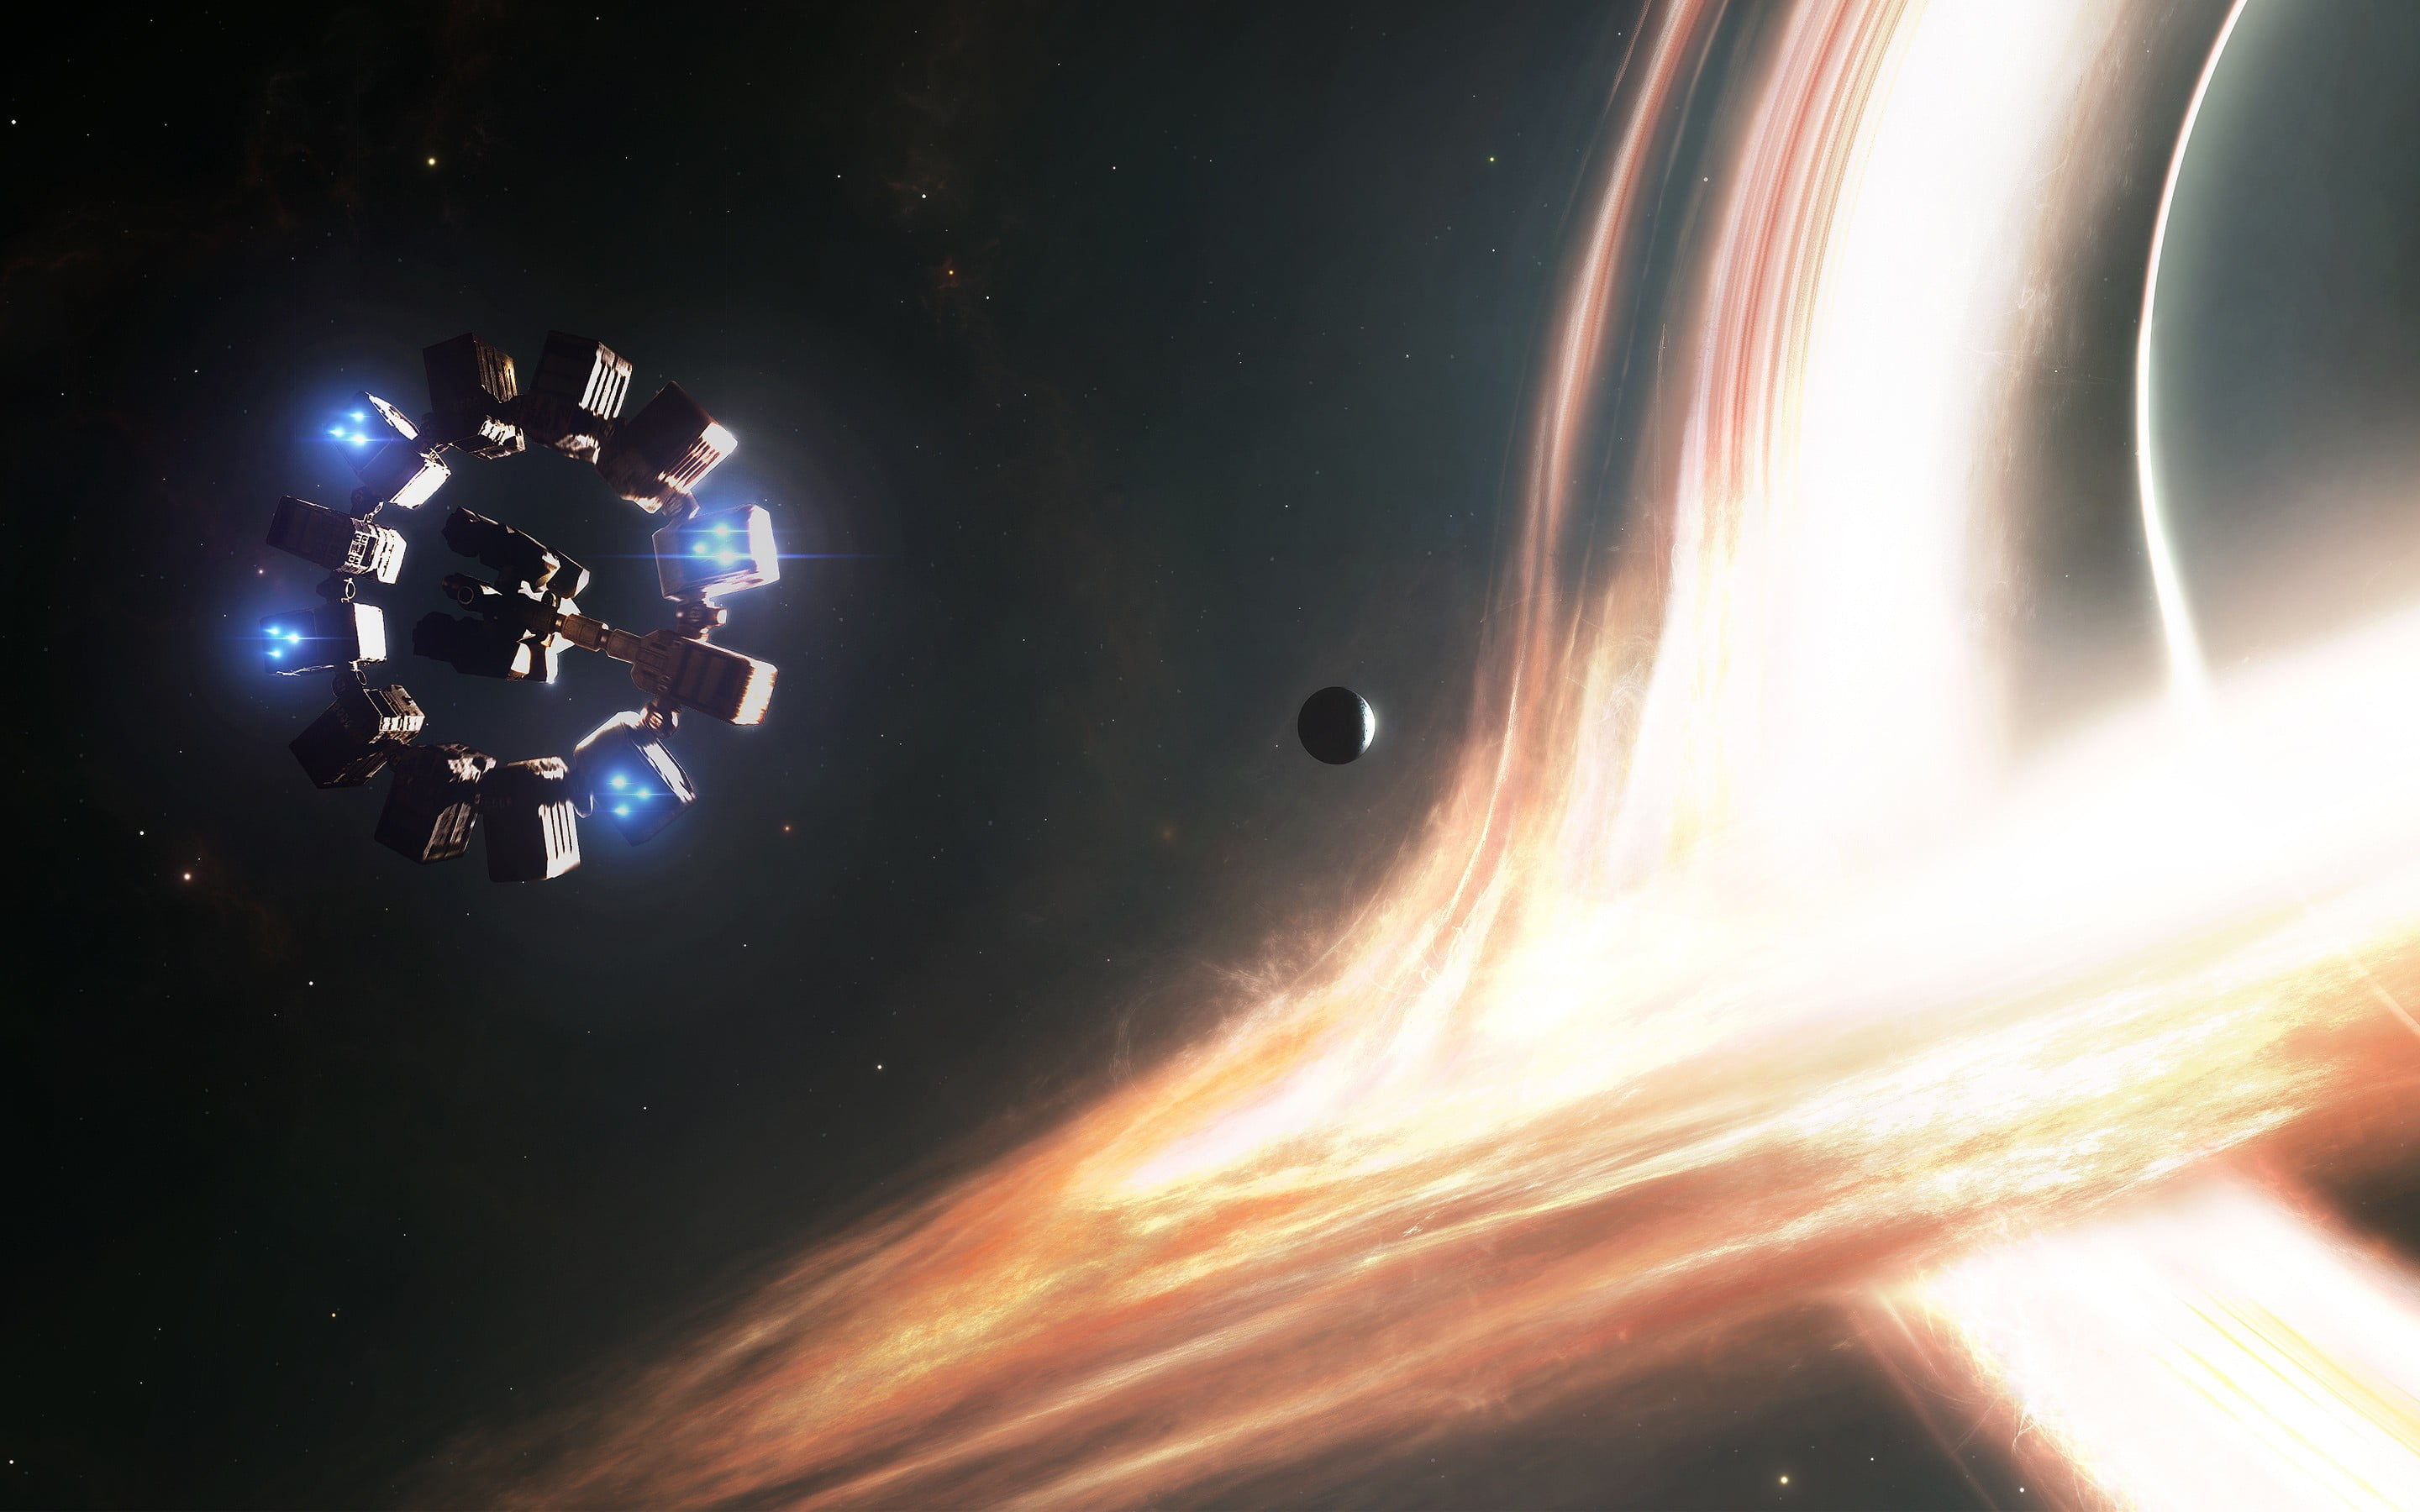

In [120]:

from PIL import Image
image_path = "/kaggle/input/jgfdlkjhgf/wallpaperflare.com_wallpaper(5).jpg"
Image.open(image_path)



![Alt text]()


## Case Study

Welcome to the year 2912, where our data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

So in this Notebook I will show how Hyperparameter Tuned Random Forest (Using GridSearchCV) gives us an accuracy of around 82.7% which is higher than other models like Logistic Regression, SVM and DT.

## Importing the necessary libraries


In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [11]:
df = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv") # df: Train.csv
df = pd.DataFrame(df)


In [12]:
df['PassengerId'].tail(10)


8683    9272_02
8684    9274_01
8685    9275_01
8686    9275_02
8687    9275_03
8688    9276_01
8689    9278_01
8690    9279_01
8691    9280_01
8692    9280_02
Name: PassengerId, dtype: object

## Visualizations

Text(0.5, 1.0, 'Number of Passengers with HomePlanets')

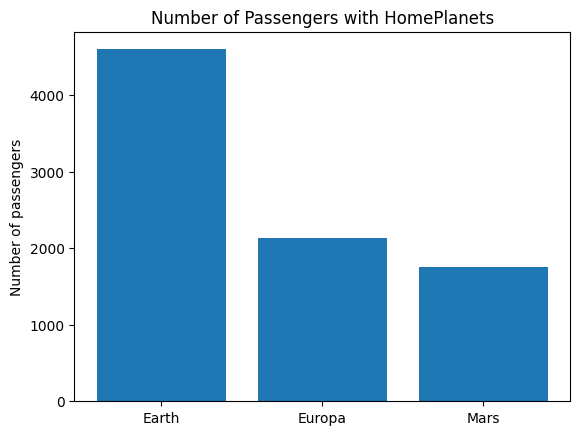

In [13]:
data = df['HomePlanet'].value_counts()
plt.bar(data.index,data.values)
plt.ylabel("Number of passengers")
plt.title("Number of Passengers with HomePlanets")

Text(0.5, 1.0, 'Age of Passengers')

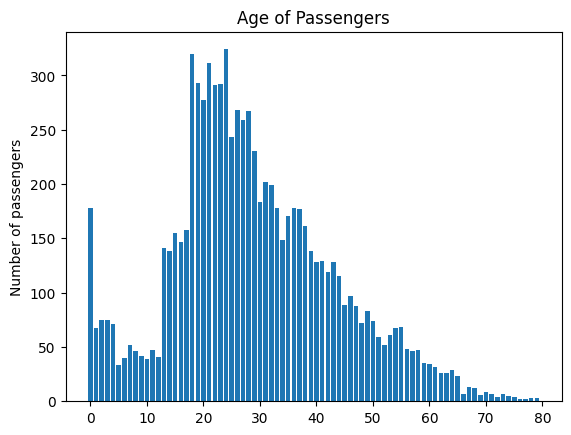

In [14]:
date = df['Age'].value_counts()
plt.bar(date.index,date.values)
plt.ylabel("Number of passengers")
plt.title("Age of Passengers")

Text(0.5, 1.0, 'Age of Passengers')

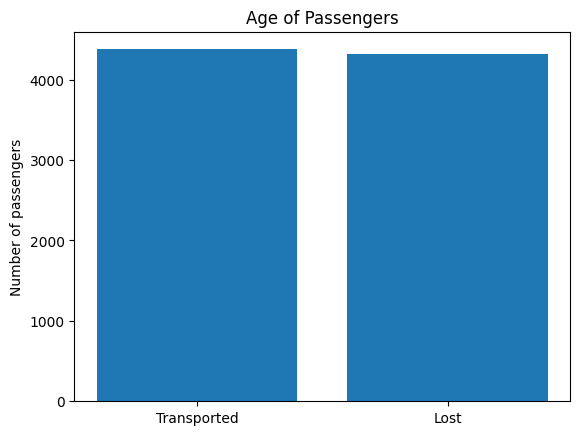

In [15]:
date = df['Transported'].value_counts()
date.index = ['Transported','Lost']
plt.bar(date.index,date.values)
plt.ylabel("Number of passengers")
plt.title("Age of Passengers")

## Data Preprocessing

As evident from the data, first we need to pre-processs the data by label encoding the categorical columns : HomePlanet, CryoSleep, Destination, Cabin and VIP

In [16]:
# Label Encoding

def wrangle(data):
    
   encoder = LabelEncoder()
   data['HomePlanet'] = encoder.fit_transform(data['HomePlanet'])

   encoder = LabelEncoder()
   data['CryoSleep'] = encoder.fit_transform(data['CryoSleep'])

   encoder = LabelEncoder()
   data['Destination'] = encoder.fit_transform(data['Destination'])

   encoder = LabelEncoder()
   data['VIP'] = encoder.fit_transform(data['VIP'])
    
   encoder = LabelEncoder()
   data['Cabin'] = encoder.fit_transform(data['Cabin'])

   
#encoder = LabelEncoder()
#df['Cabin'] = encoder.fit_transform(df['Cabin'])
# Dropping the NaN  rows from our dataset
   
   data = data.drop(columns = ['Name'])
   return pd.DataFrame(data)


In [17]:
df = wrangle(df)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   int64  
 2   CryoSleep     8693 non-null   int64  
 3   Cabin         8693 non-null   int64  
 4   Destination   8693 non-null   int64  
 5   Age           8514 non-null   float64
 6   VIP           8693 non-null   int64  
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), int64(5), object(1)
memory usage: 823.6+ KB


/tmp/ipykernel_33/2485584284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_data.dropna(inplace  = True)
/opt/conda/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


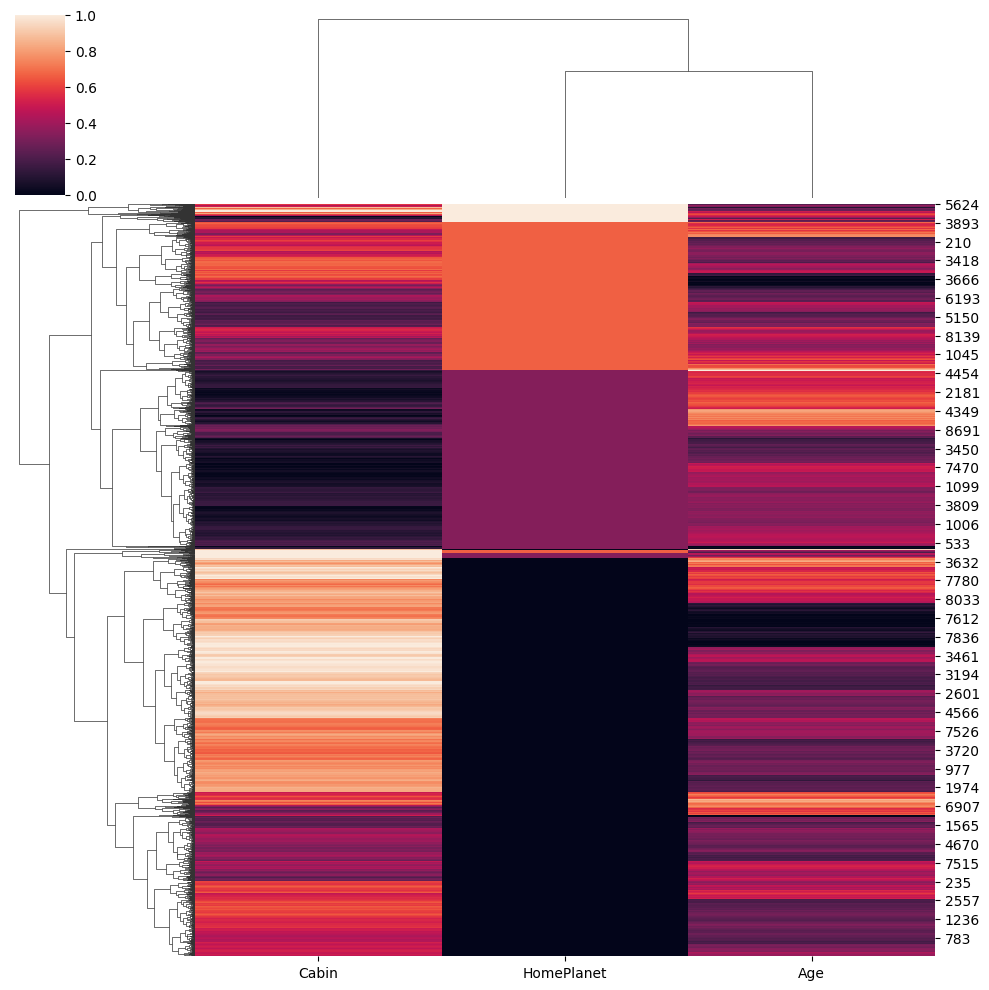

In [19]:
num_data = df[["HomePlanet", "Age","Cabin"]]
num_data.dropna(inplace  = True)
sns.clustermap(num_data, standard_scale = 1)

In [20]:
df.dropna(inplace = True)


In [21]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,1,0,149,2,39.0,0,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,0,0,2184,2,24.0,0,109.0,9.0,25.0,549.0,44.0,True
2,0003_01,1,0,1,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False
3,0003_02,1,0,1,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False
4,0004_01,0,0,2186,2,16.0,0,303.0,70.0,151.0,565.0,2.0,True


In [22]:
# Encoding the target column in train.csv
encoder = LabelEncoder()
df['Transported'] = encoder.fit_transform(df['Transported'])
#df = df.drop(columns = ['PassengerId'])

In [74]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,1,0,149,2,39.0,0,0.0,0.0,0.0,0.0,0.0,0
1,0002_01,0,0,2184,2,24.0,0,109.0,9.0,25.0,549.0,44.0,1
2,0003_01,1,0,1,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0
3,0003_02,1,0,1,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0
4,0004_01,0,0,2186,2,16.0,0,303.0,70.0,151.0,565.0,2.0,1


In [75]:
# Feature target split
X = df.iloc[:,1:12] # feature (all columns excpet the target column : Transported)
y = df.iloc[:,-1] # Target (Only the target column : Transported)

## Training and Testing
Before testing our model on the actual test dataset, we will test it over the the train dataset only using train test split 

In [76]:
# Train test Split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)
print(y_test.shape)

(1524,)


In [77]:
X_train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
4665,0,1,6273,1,25.0,0,0.0,0.0,0.0,0.0,0.0
3471,1,0,1065,0,30.0,0,0.0,787.0,116.0,1924.0,2.0
7122,0,1,4874,0,0.0,0,0.0,0.0,0.0,0.0,0.0
5929,0,0,4596,1,22.0,0,0.0,0.0,0.0,48.0,653.0
5630,0,0,2537,2,24.0,0,276.0,0.0,0.0,0.0,489.0


In [78]:
rf = RandomForestClassifier()
lr = LogisticRegression()
svc = SVC()

In [79]:
rf.fit(X_train,y_train)

RandomForestClassifier()

In [80]:
""""
def rfpredict_pro(train_df, rf):
    
    train_df = train_df.dropna()
    predictions = pd.DataFrame(rf.predict(train_df.iloc[:, 1:11]), columns=['Predictions'])
    train_df['Transported'] = predictions['Predictions']
    
    return train_df

"""
y_pred = rf.predict(X_test) # slicing the X_test so as to remove Passenger ID and Transported columns

In [81]:
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [82]:
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)

0.8103674540682415


So here we are getting an accuracy of over 80% through our simple Random Forest Algorithm

In [83]:
# lest try through SVC

svc.fit(X_train,y_train)
y_pred2 = svc.predict(X_test)
accuracy = accuracy_score(y_test,y_pred2)
print(accuracy)


0.8123359580052494


In [84]:
# lets try through SVC

lr.fit(X_train,y_train)
y_pred2 = lr.predict(X_test)
accuracy = accuracy_score(y_test,y_pred2)
print(accuracy)


0.8018372703412073


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


So here we can see that we are getting the highest accuracy uptill through RF.
 Hence we will try to tune the Hyperparameters of RF

## GridSearchCV

In [85]:
# Number of trees in random forest
n_estimators = [20,60,100,120]

# Number of features to consider at every split
max_features = [0.2,0.6,1.0]

# Maximum number of levels in tree
max_depth = [2,8,None]

# Number of samples
max_samples = [0.5,0.75,1.0]

# 108 diff random forest with different parameters
# here we are storing the whole tuning to be tested by gridsearch,
# in a dictionary called param_grid, which can be called directly later on.

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
              'max_samples':max_samples
             }
print(param_grid)

{'n_estimators': [20, 60, 100, 120], 'max_features': [0.2, 0.6, 1.0], 'max_depth': [2, 8, None], 'max_samples': [0.5, 0.75, 1.0]}


In [87]:
from sklearn.model_selection import GridSearchCV

rf_grid = GridSearchCV(estimator = rf, # selectiong the model, 
                       param_grid = param_grid, # calling the tunings to be checked stored in a dict 
                       cv = 5, # number of times to be done
                       verbose=2, # this is for selecting the type of output
                       n_jobs = -1) # this just for increasing the speed for testing 540 Random Forests

De-comment the following cell to train the grid search CV RF on the Dataset again

In [ ]:
# Training the Model

rf_grid.fit(X_train,y_train)

# Since the grid search model has been trained, now we can extract the best 
# possible parameters found by our algo so that we don't have to run the model repeatedly

rf_grid.best_params_

So the bets parameters as per the last run were : {'max_depth': 8, 'max_features': 0.6, 'max_samples': 1.0, 'n_estimators': 60}

In [92]:
rf_nice = RandomForestClassifier(max_depth= 8, max_features= 0.6, max_samples= 1.0, n_estimators= 60)

In [94]:
rf_nice.fit(X_train,y_train)
nice_pred = rf_nice.predict(X_test)
print(accuracy_score(y_test,nice_pred))

0.8267716535433071


In [95]:
y_pred_max = pd.DataFrame(nice_pred)
y_pred_max[:]

,0
0,0
1,1
2,0
3,0
4,0
...,...
1519,0
1520,0
1521,0
1522,0


Hence, we have successfully increased the accuracy of RF model to >82%. 

## Generating Final Results
The next final step would be to fit our model on the test.csv dataset and the generate the result for Submission

In [96]:
df2 = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
df2.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [97]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [98]:
df2 = wrangle(df2)

Since we have a lot of NaN rows in our Test data, we will use Simple Imputer here.

In [99]:
# Imputation

from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy='mean')
df2 = num_imputer.fit_transform(df2)

df2 = pd.DataFrame(df2)

In [100]:
df2.columns = ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [102]:
df3 = df2.drop(columns = ['PassengerId'])

In [103]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    4277 non-null   float64
 1   CryoSleep     4277 non-null   float64
 2   Cabin         4277 non-null   float64
 3   Destination   4277 non-null   float64
 4   Age           4277 non-null   float64
 5   VIP           4277 non-null   float64
 6   RoomService   4277 non-null   float64
 7   FoodCourt     4277 non-null   float64
 8   ShoppingMall  4277 non-null   float64
 9   Spa           4277 non-null   float64
 10  VRDeck        4277 non-null   float64
dtypes: float64(11)
memory usage: 367.7 KB


In [104]:
x_test = df3

In [105]:
def result(x_test):
    Transported = rf_nice.predict(x_test)
    
    result_df = pd.DataFrame({
    'PassengerIdd': df2['PassengerId'][x_test.index],  # Select passenger IDs corresponding to test set indices
    'Transported': Transported
     })

    return result_df


In [106]:
resultt = result(x_test)

In [112]:
original_test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
resultt["PassengerIdd"] = original_test['PassengerId']

In [118]:
resultt = resultt.rename(columns={'PassengerIdd': 'PassengerId'})
resultt.head()

,PassenegerId,Transported
0,0013_01,1
1,0018_01,0
2,0019_01,1
3,0021_01,1
4,0023_01,1


In [116]:
resultt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PassenegerId  4277 non-null   object
 1   Transported   4277 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 100.2+ KB


In [117]:
resultt.to_csv('submission.csv', index=False)